In [3]:
from tqdm import tqdm
from sklearn import metrics
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizerFast, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

# !git clone https://github.com/tnshp/Academic_email_classification.git
#clone the repo for training on collab

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [24]:
#parameter
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Datasets and Dataloader

In [21]:
from Academic_email_classification.data.dataloader import EmailDataset

dataset = EmailDataset('Academic_email_classification/data/mails', tokenizer)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.5, 0.2, 0.3])

In [22]:
len(train_dataset)

4701

In [25]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }


training_loader = DataLoader(train_dataset, **train_params)
validation_loader = DataLoader(train_dataset, **valid_params)
testing_loader = DataLoader(train_dataset, **test_params)


In [26]:
from Academic_email_classification.src.classifier.DistillBERT import DistilBERTClass

model = DistilBERTClass()
model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

## Training 

In [27]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

train_loss_list = []
val_loss_list = []

def train(epoch):
    model.train()
    avg_train_loss = 0
    avg_val_loss = 0

    loop = tqdm(training_loader, leave=True)
    for _,data in enumerate(loop):
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

    avg_train_loss = avg_train_loss / len(training_loader)
    train_loss_list.append(avg_train_loss)

    #validation loop
    with torch.no_grad():
        for _,data in tqdm(enumerate(training_loader)):
          ids = data['ids'].to(device)
          mask = data['mask'].to(device)
          token_type_ids = data['token_type_ids'].to(device)
          targets = data['targets'].to(device)

          outputs_val = model(ids, mask, token_type_ids)
          loss = loss_fn(outputs_val, targets)
          avg_val_loss += loss.item()

    avg_val_loss = avg_val_loss / len(validation_loader)
    val_loss_list.append(avg_val_loss)

    print('Epoch {}: train loss {} val loss {}'.format(epoch, avg_train_loss, avg_val_loss))



In [29]:
for epoch in range(EPOCHS):
    train(epoch)
    #checkpointing
    if(epoch % 5 ==0 ):
        torch.save(model.state_dict(), f'Academic_email_classification/weights/DistillBERT.pt')

  0%|          | 0/294 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Epoch 0: 100%|██████████| 294/294 [00:53<00:00,  5.53it/s, loss=0.0195]
294it [00:19, 15.30it/s]


Epoch 0: train loss 0.14119282186816948 val loss 0.024650329020710623


Epoch 1: 100%|██████████| 294/294 [00:53<00:00,  5.54it/s, loss=0.00882]
294it [00:19, 15.33it/s]


Epoch 1: train loss 0.020508188805004365 val loss 0.01156372960568184


Epoch 2: 100%|██████████| 294/294 [00:53<00:00,  5.54it/s, loss=0.00553]
294it [00:18, 16.22it/s]


Epoch 2: train loss 0.011914392366219743 val loss 0.007413786360803916


Epoch 3: 100%|██████████| 294/294 [00:52<00:00,  5.55it/s, loss=0.0037]
294it [00:17, 16.34it/s]


Epoch 3: train loss 0.009191502798760475 val loss 0.005503090583960063


Epoch 4: 100%|██████████| 294/294 [00:53<00:00,  5.54it/s, loss=0.00292]
294it [00:18, 16.24it/s]


Epoch 4: train loss 0.005858897084218203 val loss 0.003042464822429378


Epoch 5: 100%|██████████| 294/294 [00:52<00:00,  5.55it/s, loss=0.00212]
294it [00:18, 16.31it/s]


Epoch 5: train loss 0.0034792624912098 val loss 0.003934580221341378


Epoch 6: 100%|██████████| 294/294 [00:53<00:00,  5.53it/s, loss=0.00166]
294it [00:17, 16.34it/s]


Epoch 6: train loss 0.003964229898296018 val loss 0.0028871357592209212


Epoch 7: 100%|██████████| 294/294 [00:53<00:00,  5.55it/s, loss=0.00141]
294it [00:17, 16.36it/s]


Epoch 7: train loss 0.0021041525915094024 val loss 0.0018033368475766866


Epoch 8: 100%|██████████| 294/294 [00:52<00:00,  5.55it/s, loss=0.00109]
294it [00:18, 16.19it/s]


Epoch 8: train loss 0.004172893111961482 val loss 0.001175332407001406


Epoch 9: 100%|██████████| 294/294 [00:52<00:00,  5.55it/s, loss=0.00108]
294it [00:17, 16.35it/s]


Epoch 9: train loss 0.0010525304552874066 val loss 0.0009115441157054917


Epoch 10: 100%|██████████| 294/294 [00:52<00:00,  5.55it/s, loss=0.000766]
294it [00:18, 16.21it/s]


Epoch 10: train loss 0.0008383655831927345 val loss 0.000740257155769473


Epoch 11: 100%|██████████| 294/294 [00:53<00:00,  5.52it/s, loss=0.000614]
294it [00:18, 16.29it/s]


Epoch 11: train loss 0.000674981928587302 val loss 0.0006147936114417326


Epoch 12: 100%|██████████| 294/294 [00:53<00:00,  5.54it/s, loss=0.000553]
294it [00:18, 16.33it/s]


Epoch 12: train loss 0.0005672496056887416 val loss 0.0005211933567640086


Epoch 13: 100%|██████████| 294/294 [00:52<00:00,  5.56it/s, loss=0.000425]
294it [00:17, 16.37it/s]


Epoch 13: train loss 0.0004733253107445796 val loss 0.00043746095982643136


Epoch 14: 100%|██████████| 294/294 [00:52<00:00,  5.56it/s, loss=0.000389]
294it [00:18, 16.15it/s]


Epoch 14: train loss 0.0004035069831515517 val loss 0.00037250017240836737


Epoch 15: 100%|██████████| 294/294 [00:52<00:00,  5.56it/s, loss=0.000324]
294it [00:17, 16.36it/s]


Epoch 15: train loss 0.0003456470018433293 val loss 0.0003215762056793612


Epoch 16: 100%|██████████| 294/294 [00:53<00:00,  5.54it/s, loss=0.000251]
294it [00:17, 16.41it/s]


Epoch 16: train loss 0.00029599469065583835 val loss 0.00027033295414092173


Epoch 17: 100%|██████████| 294/294 [00:52<00:00,  5.56it/s, loss=0.00022]
294it [00:18, 16.20it/s]


Epoch 17: train loss 0.0002510381268466455 val loss 0.0002319894418822044


Epoch 18: 100%|██████████| 294/294 [00:52<00:00,  5.56it/s, loss=0.000192]
294it [00:17, 16.36it/s]


Epoch 18: train loss 0.0002163867258267211 val loss 0.00019922104720968665


Epoch 19: 100%|██████████| 294/294 [00:53<00:00,  5.55it/s, loss=0.000168]
294it [00:17, 16.37it/s]

Epoch 19: train loss 0.00018510220361102157 val loss 0.00017192837499877198


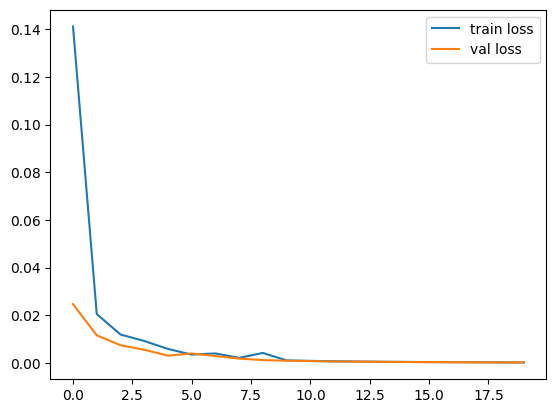

In [31]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='val loss')
plt.legend()
plt.show()

In [32]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            # fin_targets.extend(targets.cpu().detach().numpy().tolist())
            # fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return outputs, targets

In [34]:
outputs, targets = validation(testing_loader)

test_loss = loss_fn(outputs, targets)
print(f'test loss: {test_loss.item()}')

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
294it [00:16, 17.43it/s]

0.00014654017286375165
